# Electrolyte Systems

In [1]:
using Clapeyron
import PyPlot; const plt = PyPlot

PyPlot

## Building electrolyte models
Electrolyte models are somewhat more challenging as they will involve 2-3 components:
* A neutral model (accounting for dispersion, hydrogen bonding, etc.)
* An ion model (accounting for electrostatics)
* A dielectric model (for implicit solvent models)

In Clapeyron, we allow for any of the neutral models to be combined with any of the ion models (DH, MSA, Born). For practical applications, we only have four models which have been properly parameterized for electrolyte systems. For this section, we'll use SAFT-VRE Mie, where neutral and ionic species need to be defined separately:

In [2]:
model = SAFTVREMie(["water"],["sodium","chloride"])

Explicit Electrolyte Model with 3 components:
 "water"
 "sodium" (+1)
 "chloride" (-1)
Neutral Model: SAFTVRMie{BasicIdeal, Float64}
Ion Model: MSABorn{Schreckenberg}
RSP Model: Schreckenberg

In principle, everything else should work exactly the same:

In [3]:
p = 1e5
T = 298.15
z = [0.99,0.05,0.05]

v = volume(model, p, T, z)

1.952283335702304e-5

What makes electrolytes a bit challenging is the need for charge neutrality. While this is generally fine when it comes to monovalent salts, verifying this for higher valency systems can become tedious. 


Further, experimentally, ions are not introduced individually. They typically appear as a salt. As such, it would be much more convenient to specify the salt composition, and then obtain the ion compositions. We have provided helper functions in Clapeyron which can handle this. First, one needs to define the salt:

In [4]:
salts = [("sodium chloride", ["sodium"=>1, "chloride"=>1])];

One can then use the `molality_to_composition(model, salts, m)` function to provide a salt molality and obtain the composition of the system:

In [5]:
m = [1.0]
z = molality_to_composition(model, salts, m)

3-element Vector{Float64}:
 0.9652230147775643
 0.01738849261121782
 0.01738849261121782

This function also ensures the salt you have defined is charge neutral.

## Activity coefficients
Unlike neutral species where the reference state in activity coefficient is the pure species, no such system can exist in electrolytes. In this case, the reference is taken to be the pure solvent limit (infinite dilution):
$$
\gamma_i^\dagger = \exp{\left(\frac{\mu_i - \mu_i^\infty}{k_\mathrm{B}T}\right)}
$$

It is from this definition that experimentalist usually obtain mean-ionic activity coefficients for salts:
$$
\gamma_\pm^{\sum_i\nu_i} = \prod_i (\gamma_i^\dagger)^{\nu_i}
$$

This is related to the solvent's osmotic coefficient through:
$$
\ln\gamma_\pm = \Phi -1 +\int_0^m \frac{\Phi-1}{m} dm
$$

These properties are inherently linked to the salt of interest. As such, while most functions still take the typical `z`, `p` and `T` inputs, to compute the mean-ionic activity coefficient and osmotic coefficient, one must specify the salt:

In [6]:
γs = mean_ionic_activity_coefficient(model, salts, p, T, m)

1×1 Matrix{Float64}:
 0.6321355333371118

We can then trace out this coefficient for a range of salt concentrations:

In [7]:
m = LinRange(0, 6, 100)
T = 298.15
p = 1e5

γs = ones(length(m))
for i in 2:length(m)
    γs[i] = mean_ionic_activity_coefficient(model, salts, p, T, m[i])[1]
end

Plotting:

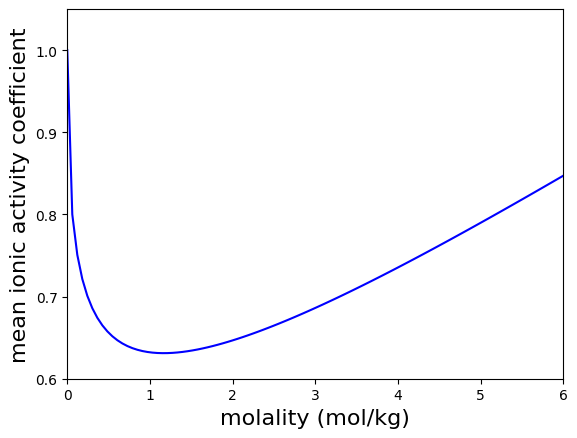

PyObject Text(30.00000000000002, 0.5, 'mean ionic activity coefficient')

In [8]:
plt.clf()
fig, ax = plt.subplots()
ax.plot(m, γs, color="blue")
ax.set_xlim(0, 6)
ax.set_ylim(0.6, 1.05)
ax.set_xlabel("molality (mol/kg)", fontsize=16)
ax.set_ylabel("mean ionic activity coefficient", fontsize=16)

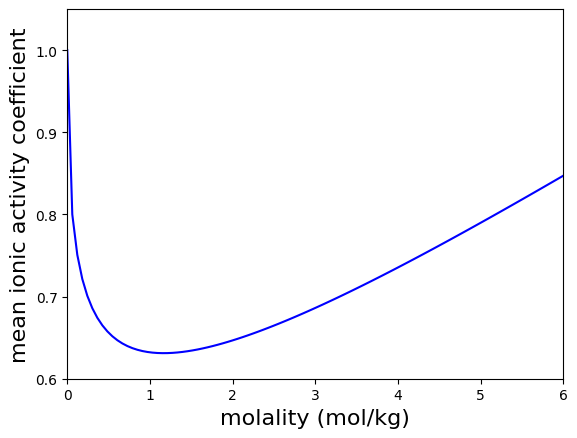

In [9]:
display(fig)

## Vapor–Liquid Equilibrium
When it comes to modelling the vapor–liquid equilibrium behavior of electrolytes, one can use a similar approximation as we did for polymers: ions are involatile. With this, we can model behavior such as the salting-in behavior of salts on the solubility of carbon dioxide:

In [10]:
model = SAFTVREMie(["water","carbon dioxide"],["sodium","chloride"])

Explicit Electrolyte Model with 4 components:
 "water"
 "carbon dioxide"
 "sodium" (+1)
 "chloride" (-1)
Neutral Model: SAFTVRMie{BasicIdeal, Float64}
Ion Model: MSABorn{Schreckenberg}
RSP Model: Schreckenberg

Specifying the method:

In [11]:
method = FugBubblePressure(nonvolatiles=["sodium","chloride"]);

Solving for a range of carbon dioxide compositions:

In [12]:
T = 323.15
m = [1e-3,1.0]

xCO2 = LinRange(0.,0.025,100)
pCO2 = zeros(length(xCO2), length(m))

for j in 1:length(m)
    for i in 1:length(xCO2)
        x = molality_to_composition(model, salts, m[j], [1-xCO2[i], xCO2[i]])
        (pCO2[i,j], _) = bubble_pressure(model, T, x, method)
    end
end

Plotting:

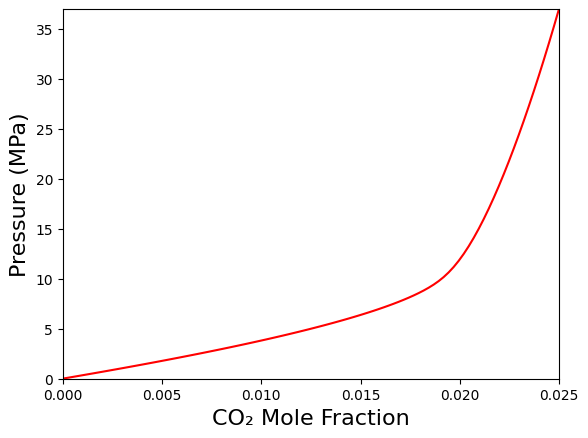

(0.0, 37.0)

In [13]:
plt.clf()
fig, ax = plt.subplots()
ax.plot(xCO2,pCO2./1e6, color="red")
ax.set_xlabel("CO₂ Mole Fraction", fontsize=16)
ax.set_ylabel("Pressure (MPa)", fontsize=16)
ax.set_xlim(0, 0.025)
ax.set_ylim(0, 37)

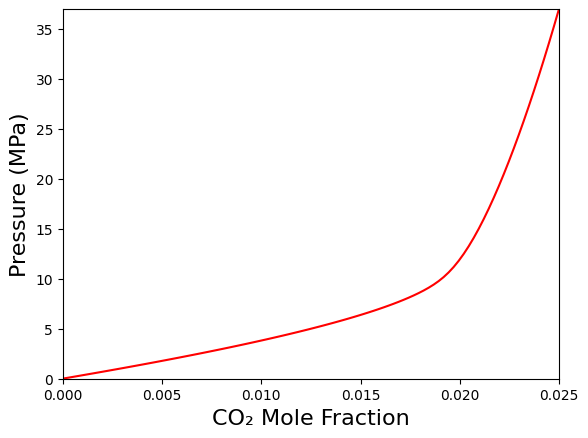

In [14]:
display(fig)

## Liquid–liquid equilibrium
Modelling liquid–liquid equilibrium in the presence of ions becomes a little bit more complicated. One typically observes salt-induced phase separation in cases where there is a large dielectric different between two miscible solvents. An example of this would be water and ethanol:

In [15]:
model = SAFTVREMie(["water","ethanol"],["sodium","chloride"]; assoc_options=AssocOptions(combining=:elliott))

Explicit Electrolyte Model with 4 components:
 "water"
 "ethanol"
 "sodium" (+1)
 "chloride" (-1)
Neutral Model: SAFTVRMie{BasicIdeal, Float64}
Ion Model: MSABorn{Schreckenberg}
RSP Model: Schreckenberg

Once again, we would like to use `tp_flash`. However, we now need to include electroneutrality within our formulation of the problem. Thankfully, this is handled automatically in Clapeyron as part of our Rachford–Rice implementation. The only problem is generating initial guesses for `K0`; there's no easy way to do this automatically. As such, these need to be provided.

In [16]:
K0 = [1e3,1e-2,1000.,10.]
method = MichelsenTPFlash(equilibrium=:lle,K0=K0, nacc=0)

p = 1e5
T = 298.15
m = [6.]
zsolv = [0.5,0.5]
z = molality_to_composition(model, salts, m, zsolv)

(x,n,G) = tp_flash(model,p,T,z,method)
x

2×4 Matrix{Float64}:
 0.561771     0.00868433  0.214772    0.214772
 0.000643281  0.994438    0.00245934  0.00245934

Diagrams like these are generally very difficult to draw as they aren't 'open' in any one of the binary mixtures. The best we can do is start from a point where we know liquid–liquid equilibrium occurs and trace towards wherever the diagram is expected to close.

In [17]:
zsolv = [0.7,0.3]
T = 298.15
p = 1e5
m = LinRange(5,1.3,500)
w1 = zeros(length(m),4)
w2 = zeros(length(m),4)
x0 = nothing
y0 = nothing
K0=[1e3,1e-2,1000.,10.]
for i in 1:length(m)
    z = molality_to_composition(model, salts, [m[i]], zsolv)

    method = MichelsenTPFlash(equilibrium = :lle, K0 = K0, y0 = y0, x0 = x0, nacc = 0)

    (x,n,G) = tp_flash(model,p,T,z,method)
    x0 = x[1,:]
    y0 = x[2,:]
    K0 = nothing
    w1[i,:] = Clapeyron.mole_to_mass(model,x[1,:])
    w2[i,:] = Clapeyron.mole_to_mass(model,x[2,:])
end

Plotting:

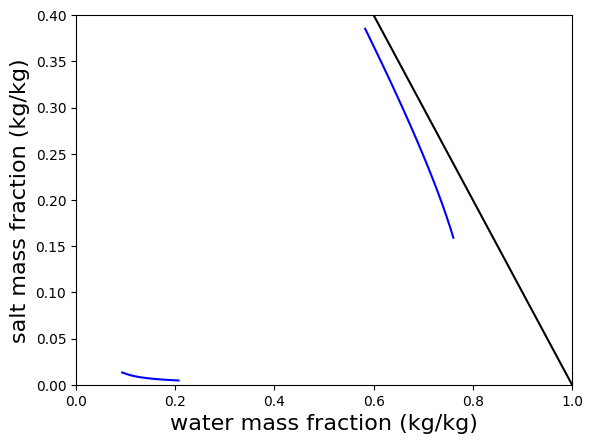

PyObject Text(30.0, 0.5, 'salt mass fraction (kg/kg)')

In [18]:
plt.clf()
fig, ax = plt.subplots()
ax.plot(w1[10:end,1],sum(w1[10:end,3:4], dims=2), color="blue")
ax.plot(w2[10:end,1],sum(w2[10:end,3:4], dims=2), color="blue")
ax.plot([0,1],[1,0], color="black")
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.4)
ax.set_xlabel("water mass fraction (kg/kg)", fontsize=16)
ax.set_ylabel("salt mass fraction (kg/kg)", fontsize=16)

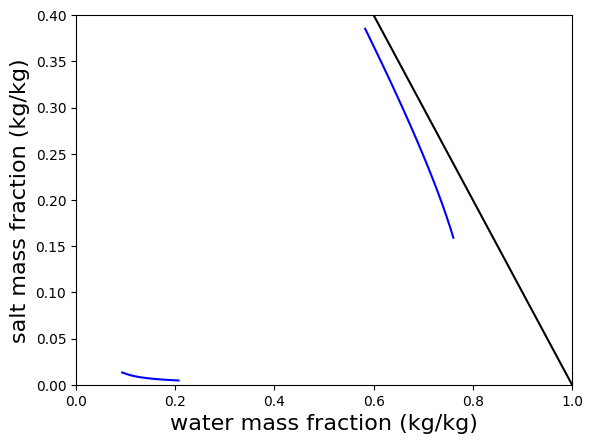

In [19]:
display(fig)

(Tried really hard to get the phase diagram to close...)

## Solid–Liquid Equilibrium
Similarly to the case of the neutral species, to model the solid–liquid equilibrium of salts in solvents, we need to construct a model for the liquid and solid phases using `CompositeModel`. Since it is a relevant system to the group, we'll consider calcium carbonate (only considering the calcite polymorph and assuming high pH):

In [2]:
fluid = SAFTVREMie(["water"],["calcium","carbonate"])

solid = SolidKs(["calcium.carbonate"])

mapping = [(("calcium",1),("carbonate",1))=>(("calcium.carbonate",1))]

model = CompositeModel(["water","calcium","carbonate"]; fluid = fluid, solid = solid, mapping = mapping)

Composite Model with 3 components:
 "water"
 "calcium"
 "carbonate"
Solid Model: SolidKs("calcium.carbonate")
Fluid Model: ESElectrolyte{BasicIdeal, SAFTVRMie{BasicIdeal, Float64}, MSABorn{Schreckenberg}}("water", "calcium", "carbonate")

This time we need a special argument (`mapping`) to link the ions and the solid salt.

Obtaining the solubility is then then same as before (although providing an initial guess becomes important):

In [3]:
sle_solubility(model,1e5, 298.15, [1.,0.,0.]; solute=["calcium.carbonate"], x0=[-7.])

3-element Vector{Float64}:
 0.999704478331042
 0.00014776083447891558
 0.00014776083447891558

We can obtain this for a range of conditions:

In [4]:
T = LinRange(288.15, 353.15, 100)
ppmCaCO3 = zeros(length(T))

for i in 1:length(T)
    ppmCaCO3[i] = sle_solubility(model, 1e5, T[i], [1.,0.,0.]; solute=["calcium.carbonate"], x0=[-7.])[2]*1e6
end

Plotting:

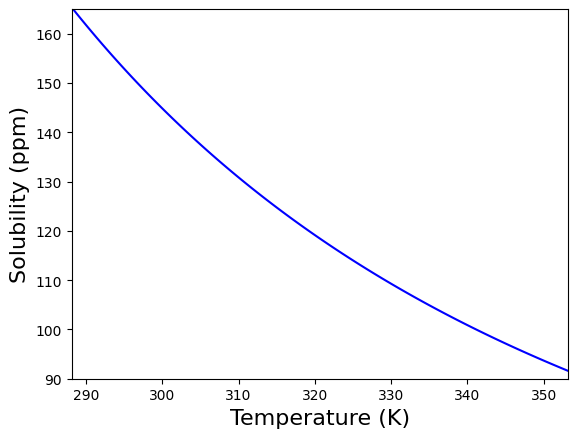

(90.0, 165.0)

In [5]:
plt.clf()
fig, ax = plt.subplots()
ax.plot(T, ppmCaCO3, label="CaCO3 Solubility", color="blue")
ax.set_xlabel("Temperature (K)", fontsize=16)
ax.set_ylabel("Solubility (ppm)", fontsize=16)
ax.set_xlim(288.15, 353.15)
ax.set_ylim(90,165)

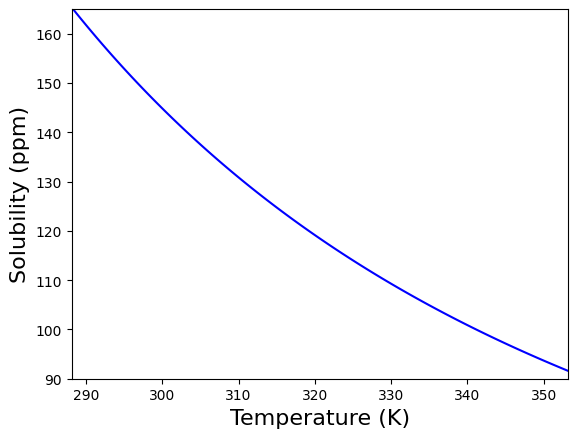

In [6]:
display(fig)